In [1]:
import tensorflow as tf
import numpy as np
import random

def set_seed(seed_value=42):
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_seed(42)  # Set seed for reproducibility

2024-09-08 00:23:25.113809: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 00:23:25.113870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 00:23:25.115464: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 00:23:25.123615: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    
    return x


def attention_gate(x, g, filters):
    x1 = layers.Conv2D(filters, (1, 1), padding='same')(x)
    g1 = layers.Conv2D(filters, (1, 1), padding='same')(g)
    
    out = layers.add([x1, g1])
    out = layers.ReLU()(out)
    out = layers.Conv2D(1, (1, 1), padding='same')(out)
    out = layers.Activation('sigmoid')(out)
    
    return layers.multiply([x, out])


2024-09-07 19:58:42.305440: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 19:58:42.305487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 19:58:42.306978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-07 19:58:42.315374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def unet_v3(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Downsampling
    c0 = residual_block(inputs, 32)
    p0 = layers.MaxPooling2D((2, 2))(c0)
    
    c1 = residual_block(p0, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = residual_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = residual_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = residual_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = residual_block(p4, 1024)
    
    # Upsampling with attention
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = attention_gate(c4, u6, 512)
    u6 = layers.concatenate([u6, c4])
    c6 = residual_block(u6, 512)
    
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = attention_gate(c3, u7, 256)
    u7 = layers.concatenate([u7, c3])
    c7 = residual_block(u7, 256)
    
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = attention_gate(c2, u8, 128)
    u8 = layers.concatenate([u8, c2])
    c8 = residual_block(u8, 128)
    
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = attention_gate(c1, u9, 64)
    u9 = layers.concatenate([u9, c1])
    c9 = residual_block(u9, 64)
    
    u10 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = attention_gate(c0, u10, 32)
    u10 = layers.concatenate([u10, c0])
    c10 = residual_block(u10, 32)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c10)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [3]:
import numpy as np

train_images = np.load("../../numpy_arr_data/train_img_224.npy")
train_masks = np.load("../../numpy_arr_data/train_mask_224.npy")

train_images.shape, train_masks.shape

((2975, 224, 224, 3), (2975, 224, 224, 1))

In [4]:
import gc
gc.collect()

65

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


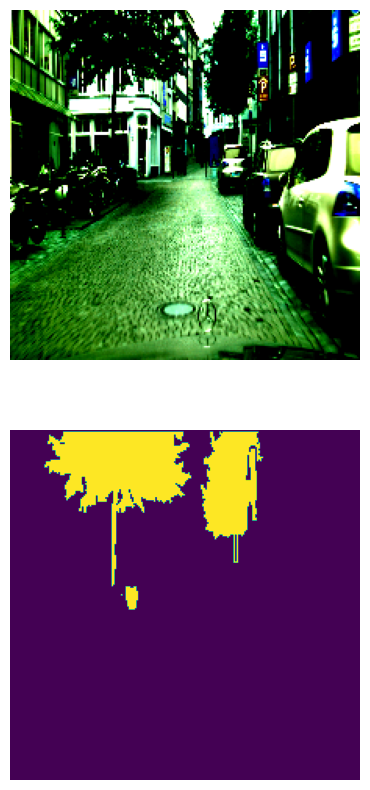

In [5]:
import matplotlib.pyplot as plt

# Example list of images (replace with your actual images)
images = [train_images[0], train_masks[0]]  # Replace with your actual images

# Number of images
num_images = len(images)

# Determine the grid size (e.g., 2 rows, 3 columns for 6 images)
rows = 2
cols = (num_images + 1) // 2

# Create a figure
plt.figure(figsize=(10, 10))

# Loop through the images and add each to a subplot
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    plt.axis('off')  # Hide the axis

# Show the plot
plt.show()

In [6]:
# Define dynamic learning rate function
def dynamic_lr(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.5  # Reduce learning rate every 10 epochs
    return lr

# Add learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(dynamic_lr)

In [ ]:
# Clear the session to avoid any potential issues with model state
tf.keras.backend.clear_session()

input_shape = (224, 224, 3)

# Define and compile the model
model = unet_v3(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train with ReduceLROnPlateau callback
history = model.fit(train_images, train_masks, epochs=50, batch_size=32, validation_split=0.2, callbacks=[reduce_lr])

Epoch 1/50
75/75 [==============================] - 84s 872ms/step - loss: 0.2334 - accuracy: 0.9053 - val_loss: 0.4110 - val_accuracy: 0.8387 - lr: 0.0010
Epoch 2/50
75/75 [==============================] - 63s 835ms/step - loss: 0.1258 - accuracy: 0.9532 - val_loss: 0.4615 - val_accuracy: 0.8033 - lr: 0.0010
Epoch 3/50
75/75 [==============================] - 63s 837ms/step - loss: 0.1160 - accuracy: 0.9565 - val_loss: 0.1847 - val_accuracy: 0.9296 - lr: 0.0010
Epoch 4/50
75/75 [==============================] - 63s 835ms/step - loss: 0.1052 - accuracy: 0.9605 - val_loss: 0.2143 - val_accuracy: 0.9053 - lr: 0.0010
Epoch 5/50
75/75 [==============================] - 63s 836ms/step - loss: 0.0946 - accuracy: 0.9649 - val_loss: 0.1148 - val_accuracy: 0.9548 - lr: 0.0010
Epoch 6/50
75/75 [==============================] - 63s 836ms/step - loss: 0.0913 - accuracy: 0.9656 - val_loss: 0.1970 - val_accuracy: 0.9336 - lr: 0.0010
Epoch 7/50
75/75 [==============================] - 63s 836ms/st

In [ ]:
model.save('../model/unet_v3_model/unet_v3_224_32_original.keras')

In [10]:
2+2

4